# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [25]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [26]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [ ]:
a = train_data.take(6)
list(a.as_numpy_iterator())[0][1]



array([8, 5, 9, 6, 9, 5, 8, 0, 6, 2, 7, 7, 4, 0, 8, 1, 5, 0, 2, 7, 0, 9,
       7, 9, 6, 0, 6, 6, 6, 7, 9, 0, 5, 2, 0, 9, 5, 6, 0, 1, 7, 0, 0, 2,
       1, 2, 2, 8, 1, 8, 9, 7, 6, 6, 3, 1, 0, 1, 4, 3, 3, 2, 3, 8, 7, 9,
       6, 8, 8, 0, 6, 0, 1, 5, 2, 4, 6, 8, 1, 0, 1, 9, 3, 3, 0, 8, 3, 7,
       7, 7, 6, 7, 4, 4, 4, 7, 5, 2, 4, 1, 3, 2, 9, 7, 6, 7, 4, 9, 1, 1,
       7, 3, 6, 7, 6, 6, 8, 0, 8, 9, 5, 9, 3, 7, 2, 8, 6, 2, 9, 1, 3, 4,
       6, 7, 0, 8, 9, 0, 4, 6, 2, 5, 0, 1, 1, 6, 3, 7, 6, 8, 0, 8, 5, 0,
       7, 2, 3, 2, 4, 6, 4, 3, 6, 2, 1, 1, 8, 7, 4, 1, 1, 6, 2, 2, 9, 6,
       1, 1, 1, 7, 4, 8, 4, 6, 0, 6, 0, 5, 9, 0, 7, 2, 8, 4, 4, 4, 9, 5,
       2, 9, 9, 2, 2, 1, 8, 2, 8, 6, 7, 0, 5, 7, 4, 9, 1, 2, 3, 5, 7, 1,
       5, 0, 4, 9, 5, 9, 5, 2, 9, 6, 9, 0, 0, 4, 0, 8, 5, 1, 4, 9, 4, 4,
       1, 2, 8, 7, 7, 9, 7, 4, 8, 1, 8, 4, 9, 1], dtype=uint8)

In [ ]:
y_train[6]

1

In [27]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        # Место для вашего кода
        self.w = tf.Variable(tf.random.normal([in_features, out_features]))
        self.b = tf.Variable(tf.zeros([out_features]))

    def __call__(self, x):
        # Место для вашего кода
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    # Место для вашего кода
    self.layer_1 = DenseLayer(in_features = 784, out_features=256)

    # Второй слой, состоящий из 256 нейронов
    # Место для вашего кода
    self.layer_2 = DenseLayer(in_features = 256, out_features=128)

    # Выходной слой
    # Место для вашего кода
    self.layer_out = DenseLayer(in_features = 128, out_features=10)

  def __call__(self, x):
    # Место для вашего кода
    x = self.layer_1(x)
    x = self.layer_2(x)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов

    x = self.layer_out(x)
    return tf.nn.softmax(x)

In [ ]:
D1 = DenseLayer(in_features = 784, out_features=256)


In [76]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

from sklearn.metrics import recall_score
# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    y_true = tf.one_hot(y_true, depth=num_classes)
    return (1-tf.reduce_sum(y_true-y_pred))

In [70]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    #w1 = pred.w
    #b1 = pred.b
    trainable_variables = nn.trainable_variables
    # Вычислим по ним значение градиента
    # Место для вашего кода
    #dw, db = g.gradient(loss, [w1, b1])
    gradient = g.gradient(loss, trainable_variables)
    
    # Модифицируем параметры
    # Место для вашего кода
    #w1.assign_sub(learning_rate*dw)
    #b1.assign_sub(learning_rate*db)
    optimizer.apply_gradients(zip(gradient, trainable_variables))

In [77]:
## Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):# Место для вашего кода
    # Обновляем веса нейронной сети
    # Место для вашего кода
    trainable_variables = neural_net.trainable_variables
    #print(neural_net(batch_x))
    train(neural_net, batch_x, batch_y)
    #accuracy(pred, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        accuracy(pred, batch_y)
        #print(pred.shape)
    
        # Место для вашего кода
        
        loss_history.append(cross_entropy(pred, batch_y))
        #
        accuracy_history.append(accuracy(pred, batch_y))
        #print(accuracy(pred, batch_y))
      

In [80]:
accuracy_history1 = []
for i in accuracy_history:
   accuracy_history1.append(i.numpy())

loss_history1 = []
for i in loss_history:
   loss_history1.append(i.numpy())

In [83]:
step = [i for i in range(0, 30, 1)]

In [54]:
print(loss_history1)

[620.9523, 580.39764, 557.93695, 538.41736, 529.74304, 517.12695, 488.221, 486.89633, 497.08258, 487.53802, 488.0821, 484.57437, 477.93774, 483.35184, 476.5011, 482.55823, 484.34045, 480.48022, 470.31903, 463.30215, 475.664, 470.34314, 469.03632, 470.60736, 466.83502, 466.37332, 459.6398, 465.83615, 458.62415, 464.93442]


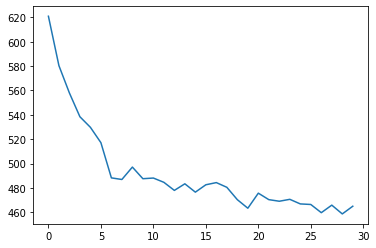

In [55]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
plt.plot(step, loss_history1[0:30])
# Место для вашего кода


In [81]:
print(accuracy_history1)

[1.0000006, 0.9999986, 1.0000002, 0.9999995, 0.9999995, 1.0000014, 0.99999917, 1.0000013, 0.99999905, 0.9999981, 1.0000012, 1.0000008, 0.9999999, 0.9999995, 1.0000032, 0.99999857, 1.0000027, 0.99999964, 1.0000002, 1.0000002, 1.000001, 1.0000007, 1.0000014, 1.0000017, 0.99999994, 1.0000007, 0.99999857, 1.000003, 1.000001, 0.9999986]


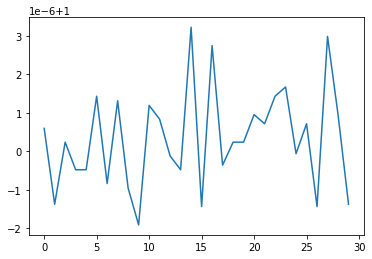

In [84]:
plt.plot(step, accuracy_history1[0:30])

In [85]:
# Вычислите точность обученной нейросети
# Место для вашего кода
s=0
for i in range(len(accuracy_history)):
  s +=accuracy_history[i] 
print((s/len(accuracy_history)).numpy())


1.0000004


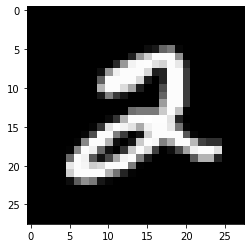

2


InvalidArgumentError: ignored

In [86]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть
#x2 = copy(x_test[4])
# Выведите изображение и выпишите рядом ответ нейросети.
plt.imshow(np.reshape(x_train[5], [28, 28]), cmap='gray')
plt.show()
print(y_train[5])
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?
neural_net(x_test[5])
# Место для вашего кода

Что тут неверно и как вызвать предсказание сети?